In [1]:
import os
import copy
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import f1_score, classification_report

import lightning as L
from lightning import Fabric

import pickle

In [2]:
DATA_DIR = 'data/img_align_celeba/img_align_celeba/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ys = pd.read_csv('data/list_attr_celeba.csv')

In [3]:
import pickle
with open('results/true_images.pickle', 'rb') as f:
    true_images_x, true_images_y = pickle.load(f)

In [4]:
true_images_x = true_images_x[:30]
true_images_y = true_images_y[:30]
true_images_x.shape, true_images_y.shape 

((30,), (30,))

In [5]:
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [6]:
alexnet_model = models.alexnet()
alexnet_model.classifier[6] = nn.Linear(4096, 1) 
alexnet_model.load_state_dict(torch.load('models/best_alexnet.pth'))
alexnet_model.eval()
alexnet_model.to(DEVICE)
pass

In [7]:
def get_pred_from_pillow(image):
    image = val_tfms(image).unsqueeze(0)
    image = image.to(DEVICE)
    with torch.no_grad():
        output = alexnet_model(image).squeeze(1)
    return torch.sigmoid(output).cpu().numpy()[0]

In [8]:
def get_perturb_image_from_pillow(img, attack, diameter=1, ga=False):
    img_arr = np.array(img)
    img_mod = img_arr.copy()
    for xi in attack:
        x_coord, y_coord, r, g, b = xi
        for delta_x in range(diameter):
            for delta_y in range(diameter):
                img_mod[y_coord + delta_y, x_coord + delta_x] = [r, g, b]
                    
    return Image.fromarray(img_mod)

In [13]:
vectors = [
    [130, 106, 79, 127, 239, 189, 117, 83, 167, 161, 129, 70, 7, 109, 111],
    [163, 84, 34, 3, 248, 109, 68, 14, 248, 253, 111, 56, 1, 201, 242],
    [130, 70, 0, 217, 9, 131, 107, 14, 27, 213, 35, 21, 52, 167, 23],
    [124, 90, 31, 17, 26, 129, 64, 11, 7, 4, 130, 114, 8, 3, 11],
    [127, 74, 4, 10, 17, 130, 88, 50, 1, 9, 130, 107, 5, 7, 7],
    [129, 104, 208, 5, 202, 126, 65, 30, 101, 3, 128, 108, 136, 8, 185]
]

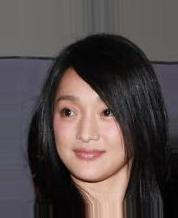

Накрашена


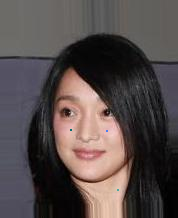

Ненакрашена


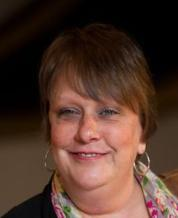

Ненакрашена


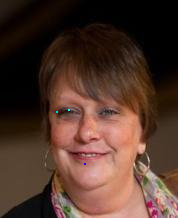

Накрашена


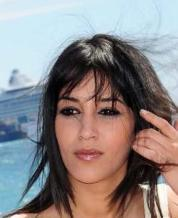

Накрашена


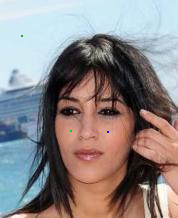

Ненакрашена


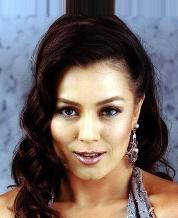

Накрашена


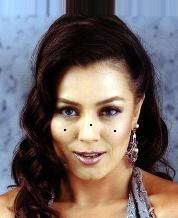

Ненакрашена


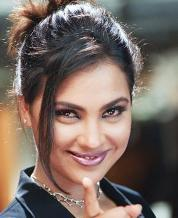

Накрашена


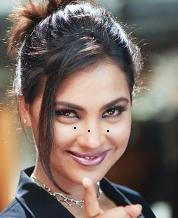

Ненакрашена


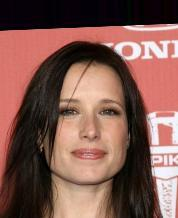

Накрашена


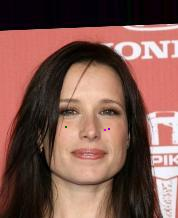

Ненакрашена


In [23]:
ids = [6, 12, 13, 16, 19, 23]

for id_, vector in zip(ids, vectors):
    print('=' * 20)
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[id_]}').convert('RGB')
    display(img_)
    print('Накрашена' if true_images_y[id_] else 'Ненакрашена')

    attack = np.array(vector).reshape(3, 5)

    for p in attack:
        p[0], p[1] = p[1], p[0]

    img = get_perturb_image_from_pillow(img_, attack, diameter=2)
    display(img)
    print('Накрашена' if get_pred_from_pillow(img) > 0.5 else 'Ненакрашена')

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class GuidedBackpropReLU(nn.Module):
    def __init__(self):
        super(GuidedBackpropReLU, self).__init__()

    def forward(self, x):
        return F.relu(x)

    def backward(self, grad_output):
        return torch.clamp(grad_output, min=0.0)

class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.hooks = []
        
        self.update_relus()
        self.hook_layers()
    
    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        
        first_layer = list(self.model.modules())[1]
        hook = first_layer.register_backward_hook(hook_function)
        self.hooks.append(hook)
    
    def update_relus(self):
        """Заменяем обычные ReLU на Guided ReLU"""
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_activation = self.forward_relu_outputs[-1]
            corresponding_activation[corresponding_activation > 0] = 1
            modified_grad_out = corresponding_activation * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out,)
        
        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
        
        for pos, module in self.model.features.named_modules():
            if isinstance(module, nn.ReLU):
                hook = module.register_backward_hook(relu_backward_hook_function)
                self.hooks.append(hook)
                hook = module.register_forward_hook(relu_forward_hook_function)
                self.hooks.append(hook)
    
    def generate_gradients(self, input_image, target_class):
        self.model.eval()
        
        input_image.requires_grad_()
        model_output = self.model(input_image)
        
        self.model.zero_grad()
        
        grad_target_map = torch.zeros(model_output.shape, dtype=torch.float)
        if torch.cuda.is_available():
            grad_target_map = grad_target_map.cuda()
        
        grad_target_map[0][target_class] = 1
        model_output.backward(gradient=grad_target_map)
        
        result = input_image.grad.data[0].cpu().numpy().transpose(1, 2, 0)
        return result
    
    def __del__(self):
        for hook in self.hooks:
            hook.remove()

def visualize_guided_backprop(model, original_image, img_id, attack_vector, target_class=None, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    prep_img = transform(original_image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(prep_img)
        if target_class is None:
            target_class = output.argmax().item()
    
    guided_bp = GuidedBackprop(model)
    
    guided_grads = guided_bp.generate_gradients(prep_img, target_class)
    
    guided_grads = guided_grads - guided_grads.min()
    guided_grads = guided_grads / guided_grads.max()
    
    guided_grads_gray = np.mean(guided_grads, axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Накрашена' if true_images_y[img_id] else 'Ненакрашена')
    axes[0].axis('off')

    attack = np.array(attack_vector).reshape(3, 5)

    for p in attack:
        p[0], p[1] = p[1], p[0]

    img = get_perturb_image_from_pillow(original_image, attack, diameter=2)
    print()
    
    axes[1].imshow(img)
    axes[1].set_title('Накрашена' if get_pred_from_pillow(img) > 0.5 else 'Ненакрашена')
    axes[1].axis('off')
    
    axes[2].imshow(guided_grads)
    axes[2].set_title('Guided Backpropagation (Color)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

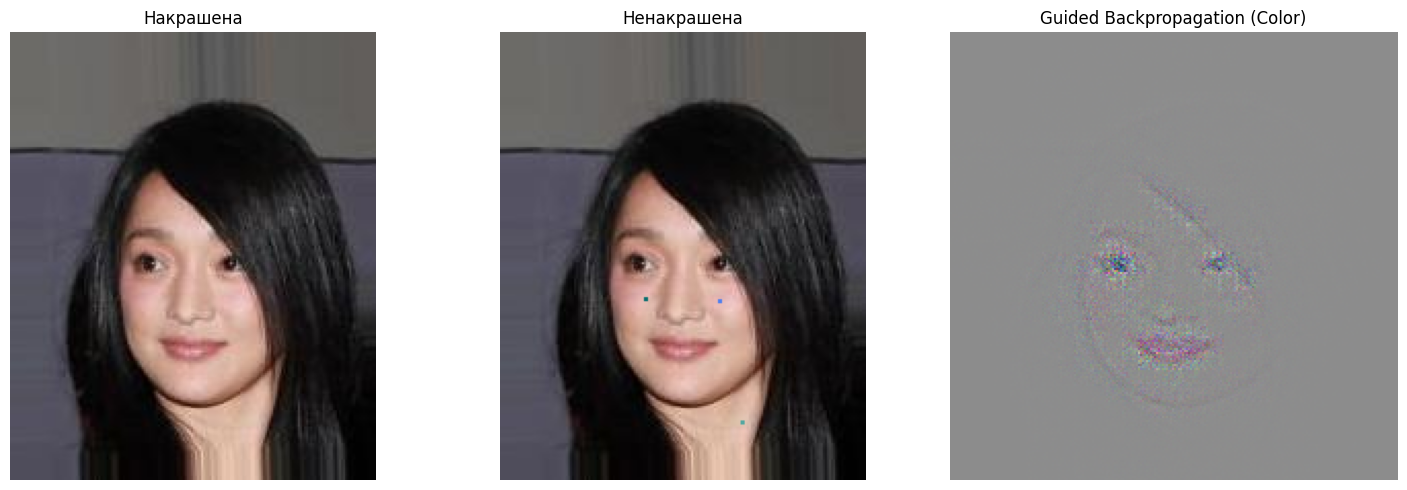

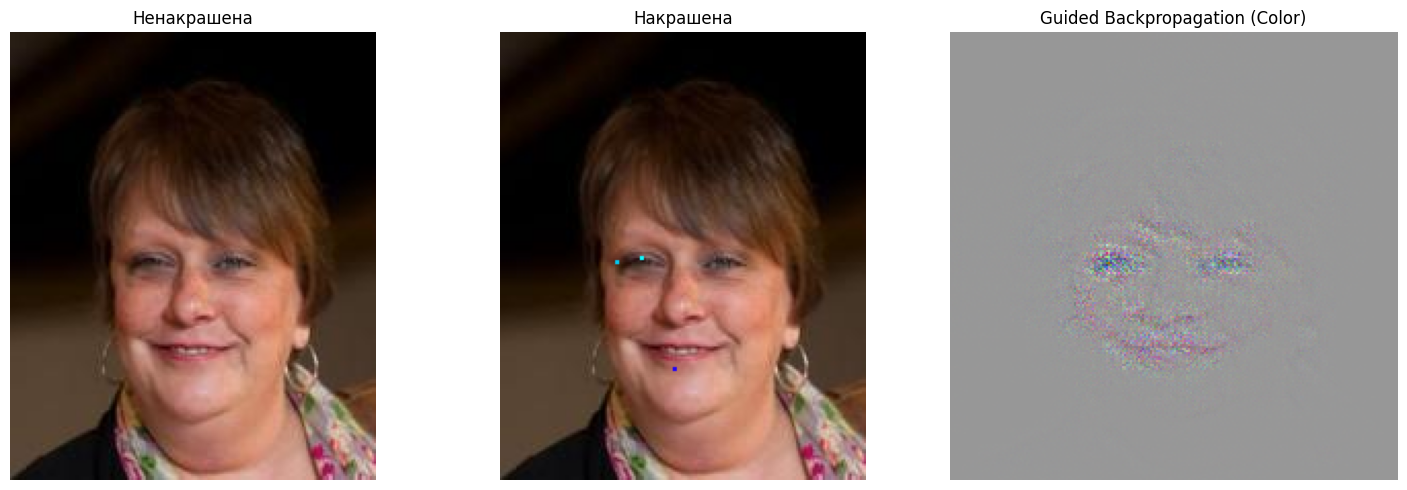

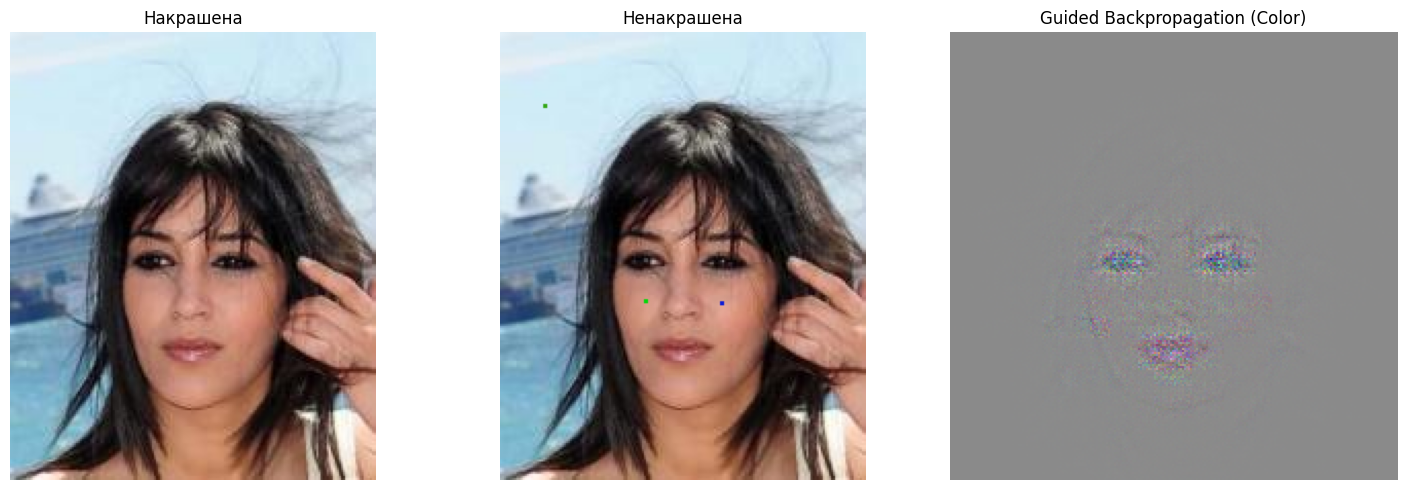

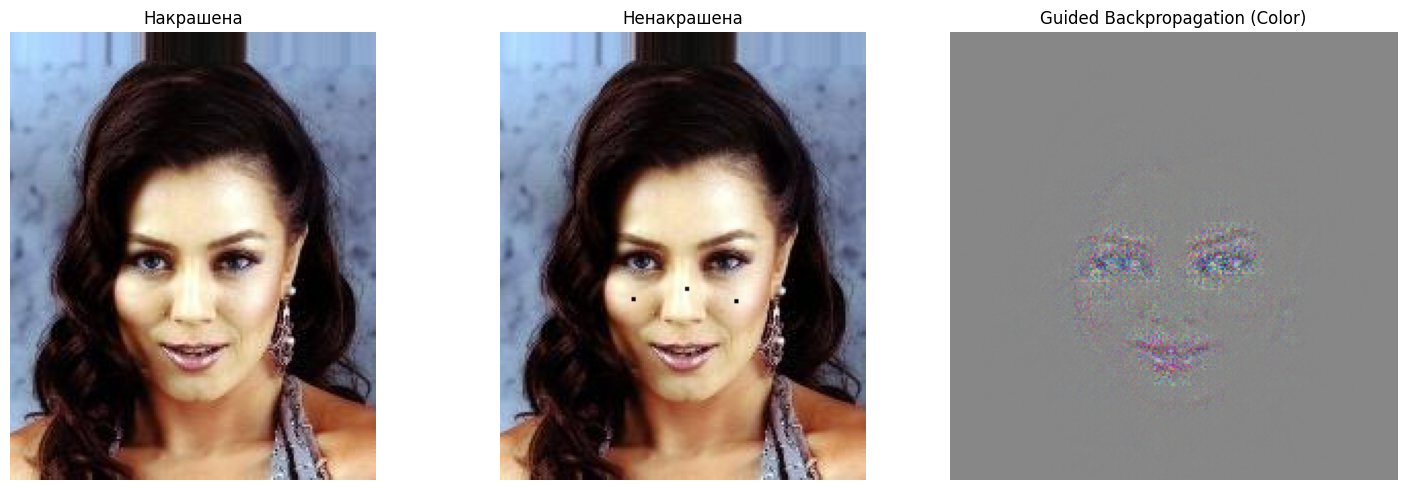

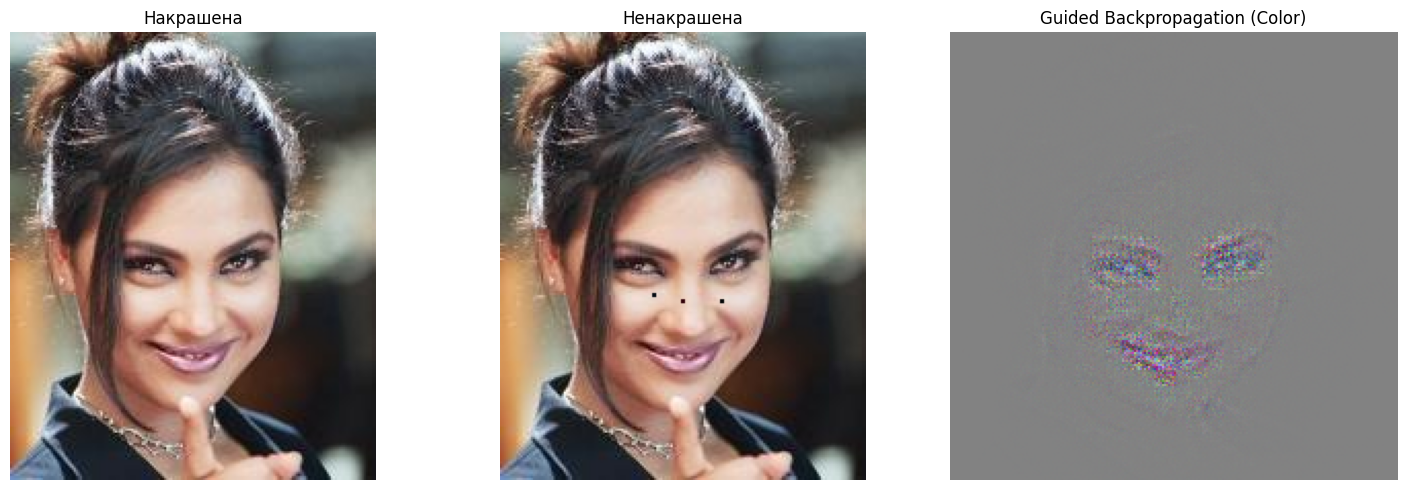

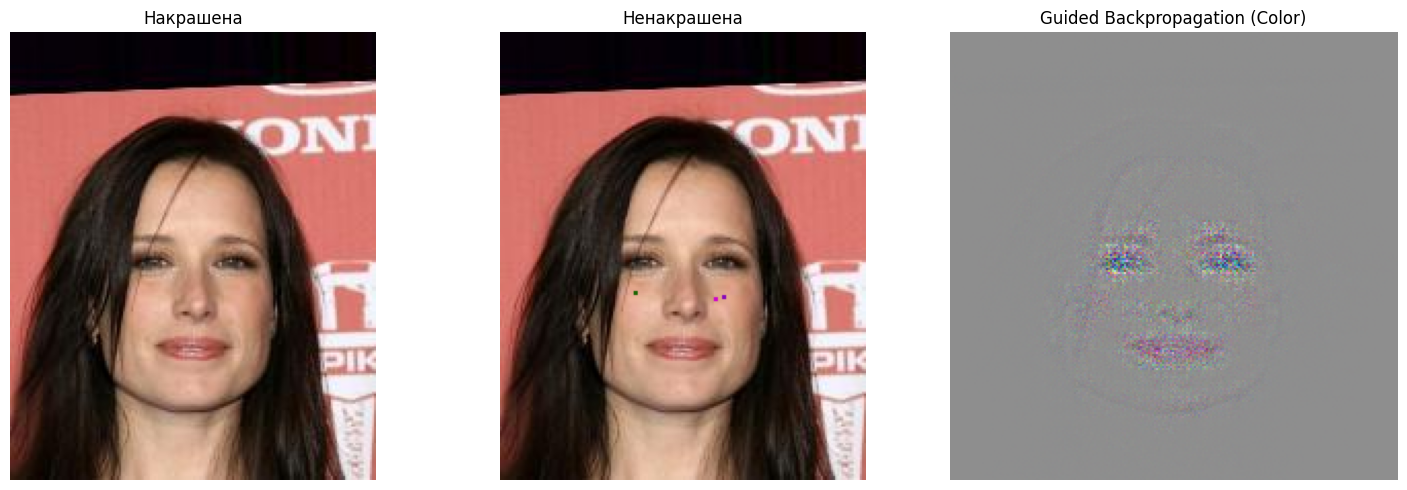

In [22]:
ids = [6, 12, 13, 16, 19, 23]

for id_, vector in zip(ids, vectors):
    print('=' * 100)
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{true_images_x[id_]}').convert('RGB')

    visualize_guided_backprop(alexnet_model, img_, id_, vector)